In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Fraud.csv")

In [3]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [4]:
df = df.drop(columns=['nameOrig', 'nameDest'])  # too many unique values, unnecessary

In [5]:
df['type'] = df['type'].astype('category').cat.codes

In [6]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      0.72      0.84      1643

    accuracy                           1.00   1272524
   macro avg       1.00      0.86      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524

Random Forest Confusion Matrix:
[[1270877       4]
 [    455    1188]]


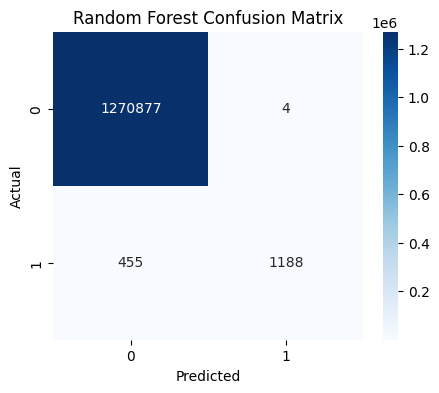

In [8]:
rf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))

rf_cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

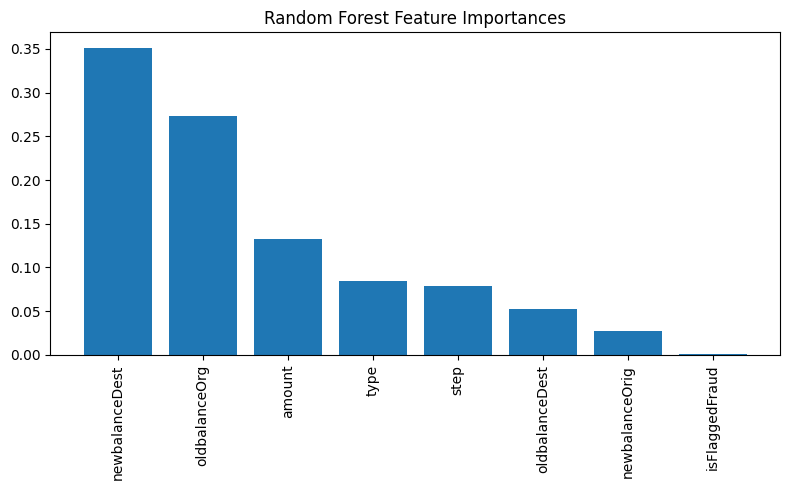

In [9]:
# Feature Importance Plot
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
plt.title("Random Forest Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.78      0.86      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

XGBoost Confusion Matrix:
[[1270817      64]
 [    360    1283]]


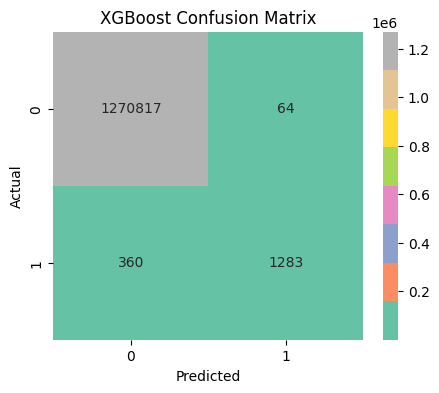

In [10]:
xgb = XGBClassifier(n_estimators=50, max_depth=6, learning_rate=0.1, eval_metric='logloss',use_label_encoder=False)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, xgb_preds))
xgb_cm = confusion_matrix(y_test, xgb_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Set2')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train) 

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


<Figure size 1000x600 with 0 Axes>

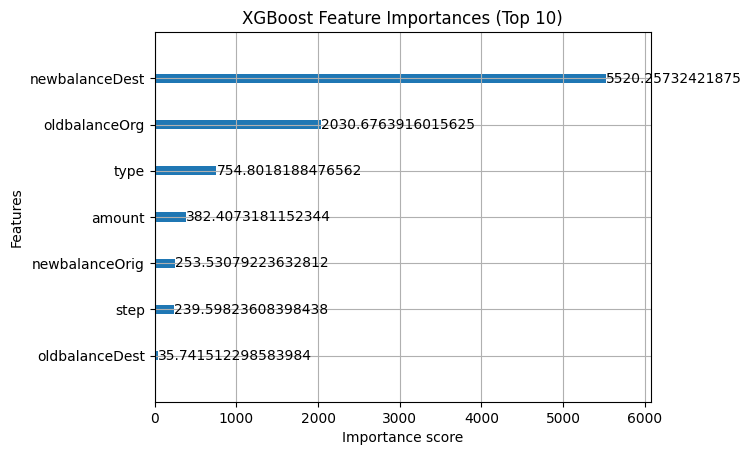

In [12]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_importance(xgb, importance_type='gain', max_num_features=10)
plt.title("XGBoost Feature Importances (Top 10)")
plt.show()

In [13]:
# ROC-AUC Comparison
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)

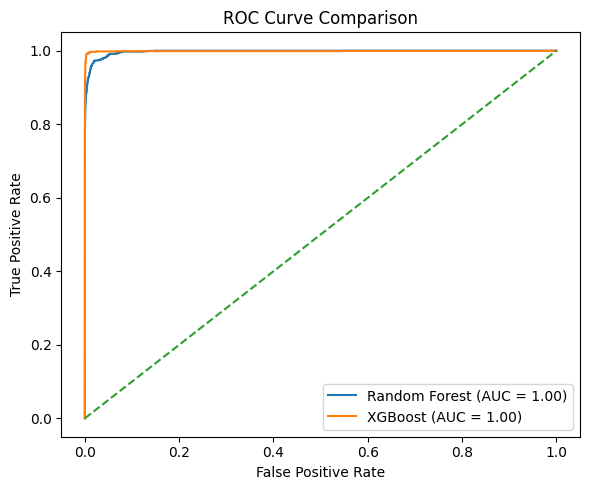

In [14]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_score(y_test, rf_probs))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_score(y_test, xgb_probs))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
rf_cv = cross_val_score(rf, X, y, cv=3, scoring='roc_auc')
xgb_cv = cross_val_score(xgb, X, y, cv=3, scoring='roc_auc')

print(f"\nRandom Forest CV AUC: {rf_cv.mean():.4f}")
print(f"XGBoost CV AUC: {xgb_cv.mean():.4f}")


Random Forest CV AUC: 0.9473
XGBoost CV AUC: 0.9956
